In [1]:
# from sys import argv

In [2]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
import numpy as np
from os.path import isdir
from os import makedirs

In [40]:
%config Completer.use_jedi = False

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
from plotFirst_1 import getApparentFreq, importFirstFrames, plotImage

In [5]:
pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Experiment30_no_lin_scan.lif'

md = bf.get_omexml_metadata(pathToFile)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()

rdr = bf.ImageReader(pathToFile, perform_init=True)

In [6]:
extension = "."+pathToFile.split(".")[-1]

In [7]:
iSeries = 7

In [8]:
im = xml.image(iSeries)
Name = im.Name
dimensions = dict(zip("TXY",(getattr(im.Pixels, "Size"+dim) for dim in "TXY")))

In [9]:
if dimensions["T"]>1:
    dimensions['freq'] = getApparentFreq(iSeries,xml)

In [10]:
dimensions

{'T': 7927, 'X': 512, 'Y': 512, 'freq': 1.981383098366963}

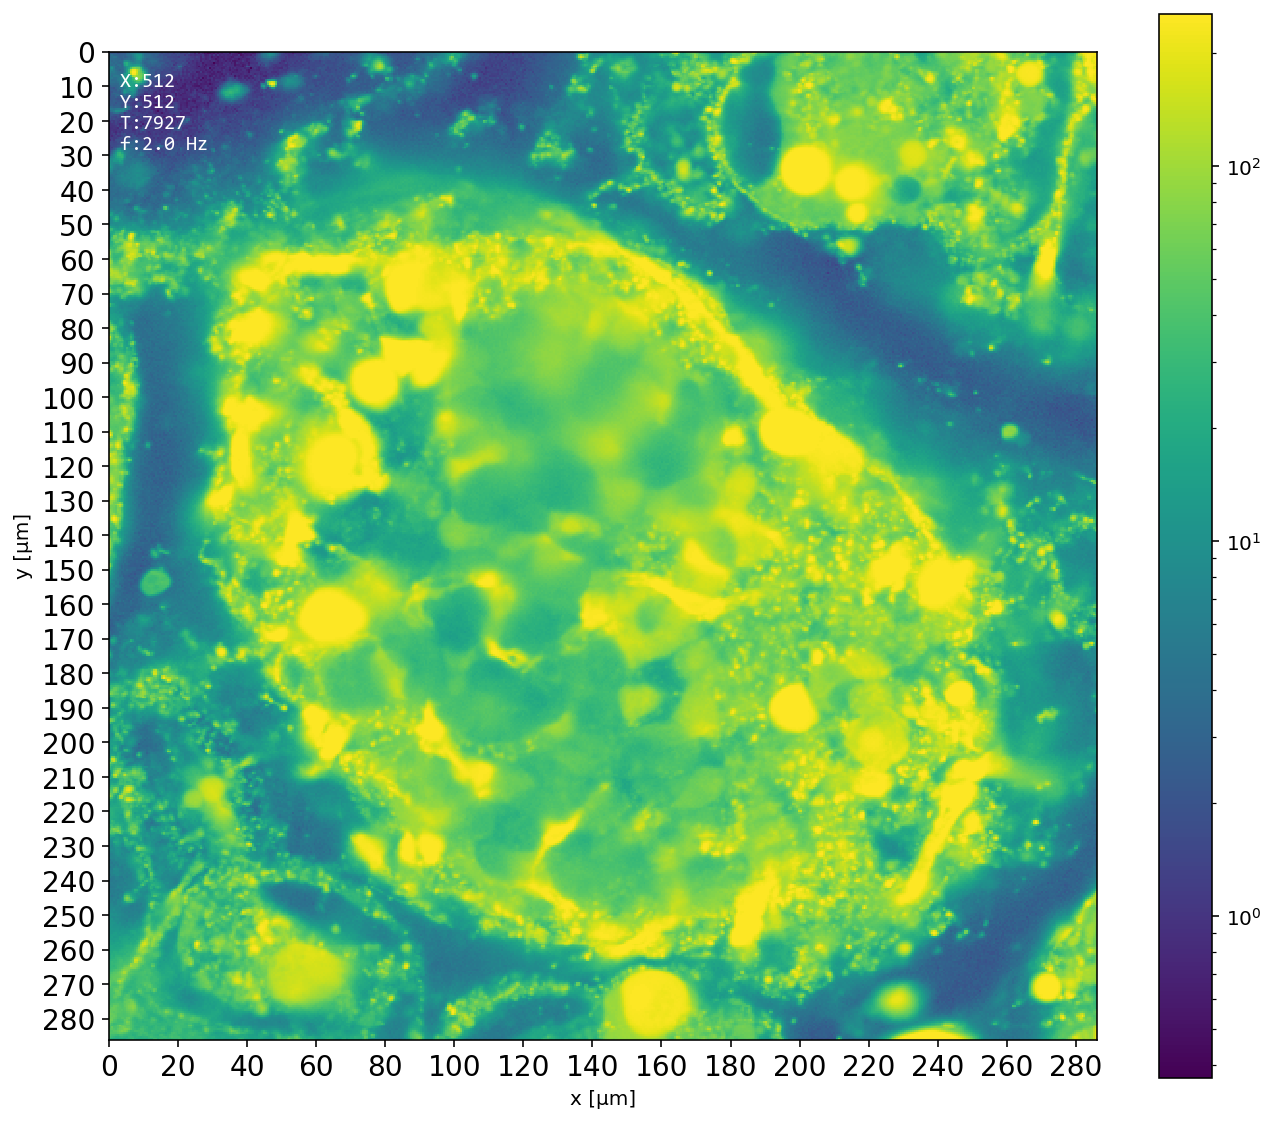

In [11]:
image = importFirstFrames(rdr,idx=iSeries).mean(axis=0)

pxSize = im.Pixels.get_PhysicalSizeX()
pxUnit = im.Pixels.get_PhysicalSizeXUnit()

text = "\n".join([" %s:%i"%(c,dimensions[c])  for c in "XYT"])

if dimensions["T"]>1:
    text += "\n f:%.1f Hz"%dimensions['freq']

plotImage(image.T,pxSize=pxSize,pxUnit=pxUnit,
          #savePath=saveDir+outName,
          addInfo=text)
plt.tight_layout()


In [375]:
Name

'Series080'

# Choose a patch to import all

In [112]:
with open("functions/physio_def_0.py") as f:
    exec(f.read())

In [114]:
image.shape

(397, 512, 512)

In [171]:
def importFrames(rdr,idx=0,which=None):
    from warnings import warn
    firstImage = rdr.read(series=idx, rescale=False, t=0)
    dims = firstImage.shape
    if which is None:
        ix = tuple(slice(None) for j in dims)
        image = []
        while True:       ######## dangerous!
            try:
                nextImage = rdr.read(series=idx, rescale=False, t=t)        
                image += [nextImage[ix]]
            except:
                break
        image = np.stack(image)
    else:
        try:
            if type(which[0]) is int:
                Ts = range(which[0]) 
            else:
                Ts = which[0]
        except:
            raise ValueError("`which` needs to NaN(s) or iterable")
        ix = tuple()
        for ix_ in which[1:]:
            try:
                ix += (slice(*ix_),)
            except:
                ix += (slice(ix_),)
        # for el in :
        #     if el is None:
        #         ix += (slice(None))
        #     else:
        #         ix += (el)
        
        image = np.zeros( (len(Ts),) + firstImage[ix].shape)
        for i,t in enumerate(Ts):
            try:
                nextImage = rdr.read(series=idx, rescale=False, t=t)        
                image[i] = nextImage[ix]
            except:
                warn(f"Could not give all required time points. I advise you double check the output")
                break
    return image

In [176]:
%%time
subimage = importFrames(rdr,idx=iSeries,which=(dimensions["T"],(100,200),(100,200)))

Wall time: 2min 36s


In [178]:
time = getTimes(xml_=xml,idx_=iSeries)

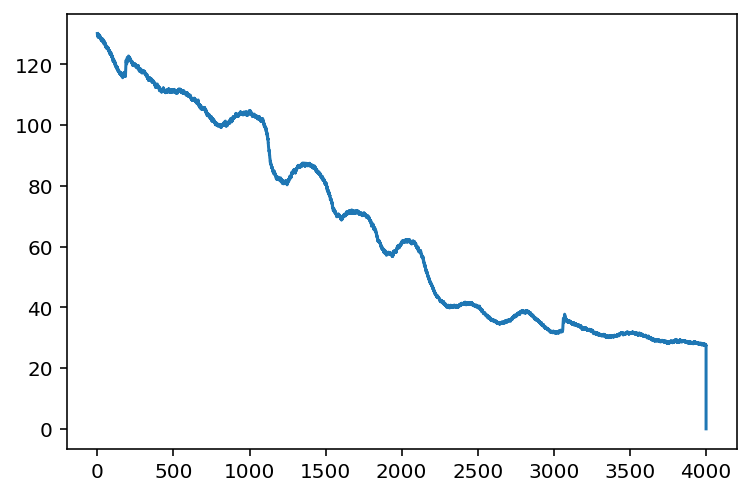

In [180]:
plt.plot(time,subimage.mean(axis=(1,2)))

In [253]:
def plotRoisOnImage(  pxShows,pxWin,
                      image_=None,
                      stdDev=False,
                      imgHeight = None,):
    from matplotlib.patches import Rectangle
    dd = .2
    if imgHeight is None:
        imgHeight = image_.shape[-1]/20
    fig,axs = plt.subplots(int(stdDev)+1,1,figsize=(15,(1+int(stdDev))*imgHeight))
    try: axs[0]
    except: axs = [axs]
    axs[0].imshow(np.log10(10+image_.mean(axis=(0)).T))
    if stdDev:
        axs[1].imshow(image_.std(axis=(0)).T)
    for j,pxShow in enumerate(pxShows):
        for ax in axs:
            xx = max(pxShow[0]-pxWin,0), min(pxShow[0]+pxWin+1,image_.shape[1])
            yy = max(pxShow[1]-pxWin,0), min(pxShow[1]+pxWin+1,image_.shape[2])
            roi = Rectangle(
                        (xx[0]-.5+dd/2,yy[0]-.5+dd/2),
                        width=xx[1]-xx[0]-dd,
                        height=yy[1]-yy[0]-dd,
                        fill=False,
                        edgecolor="C1"
                    )
            ax.add_patch(roi)
            ax.text(xx[0],yy[0],j,va="top",color="C1")
    fig.tight_layout()
    return axs

In [364]:
def multiProfilePlotWithRoi(pxShows,pxWin,
                          timeWindow=None,
                          timeAverageWindow=1,
                          times_=None,
                          image_=None,
                          firstDeriv=False,
                          stdDev=False,
                          showRaw=False,
                          imgHeight = None,
                          onSame=False,
                          Offset_ = 0.2,
                          outProfiles = False
                          ):
    if times_ is None: times_ = times
    if image_ is None: image_ = image
    if timeWindow is None:
        timeWindow = (times_.min(), times_.max())
    twSlice = slice(*(np.where(times_>=tl)[0][0] for tl in timeWindow))
    times_ = times_[twSlice]
    rebTime    = rebin(times_ , timeAverageWindow,0)
    
    plotRoisOnImage(  pxShows,pxWin,
                      image_=image_,
                      stdDev=stdDev,
                      imgHeight = imgHeight,)
   
    def plotSingle(ax,offset_=0,label="time profile for the roi"):
        xx = max(pxShow[0]-pxWin,0), min(pxShow[0]+pxWin+1,image_.shape[1])
        yy = max(pxShow[1]-pxWin,0), min(pxShow[1]+pxWin+1,image_.shape[2])
        ii = (twSlice, slice(*xx), slice(*yy) )
        profile = image_[ii].mean(axis=(1,2))
        rebProfile = rebin(profile, timeAverageWindow,0)
        
        c = ax.plot(rebTime,rebProfile+offset_,lw=1,label=label)[0].get_color()
        if showRaw: ax.plot(times_,profile+offset_,"-",lw=.3,ms=2,c=c)
        if firstDeriv:
            offset = np.percentile(profile,5)-profile.std()
            c = ax.plot(rebTime[:-1],np.diff(rebProfile)+offset,lw=1,label="first derivative")[0].get_color()
            if showRaw: ax.plot(times_[:-1],np.diff(profile)+offset,lw=.3,c=c)
        if outProfiles:
            return profile
    Profiles = []
    if onSame:
        fig,ax = plt.subplots(1,1,figsize=(15,7))
        for j in range(len(pxShows)):
            pxShow = pxShows[j]
            Profiles += [plotSingle(ax,offset_=image_.max()*Offset_*j,label="%i"%j)]
        ax.set_xlim((timeWindow))
        ax.legend(loc=(1.01,.01),ncol=len(pxShows)//20+1)
        ax.grid()
        axs=ax
    else:
        fig,axs = plt.subplots(len(pxShows),1,figsize=(15,2.5*len(pxShows)))
        try: axs[0]
        except:
            axs = [axs]
        for j in range(len(pxShows)):
            ax = axs[j]
            pxShow = pxShows[j]
            Profiles += [plotSingle(ax)]
            ax.set_xlim((timeWindow))
            ax.text(0,1,"\n  %i"%j,va="top",transform=ax.transAxes)
            ax.legend()
            ax.grid()
    if outProfiles:
        return axs,Profiles
    else:
        return axs

In [453]:
# pxs = array([
#    [23,  8],
#    [62, 19],
#    [62,  3]])
np.random.seed(0)
Nrois = 100
pxs = np.array([np.random.randint(j,size=(Nrois)) for j in subimage.shape[1:]]).T
# pxs = [for i in range()]

In [454]:
slowTimescale = 30 # in seconds
tWin=int(slowTimescale*dimensions["freq"])

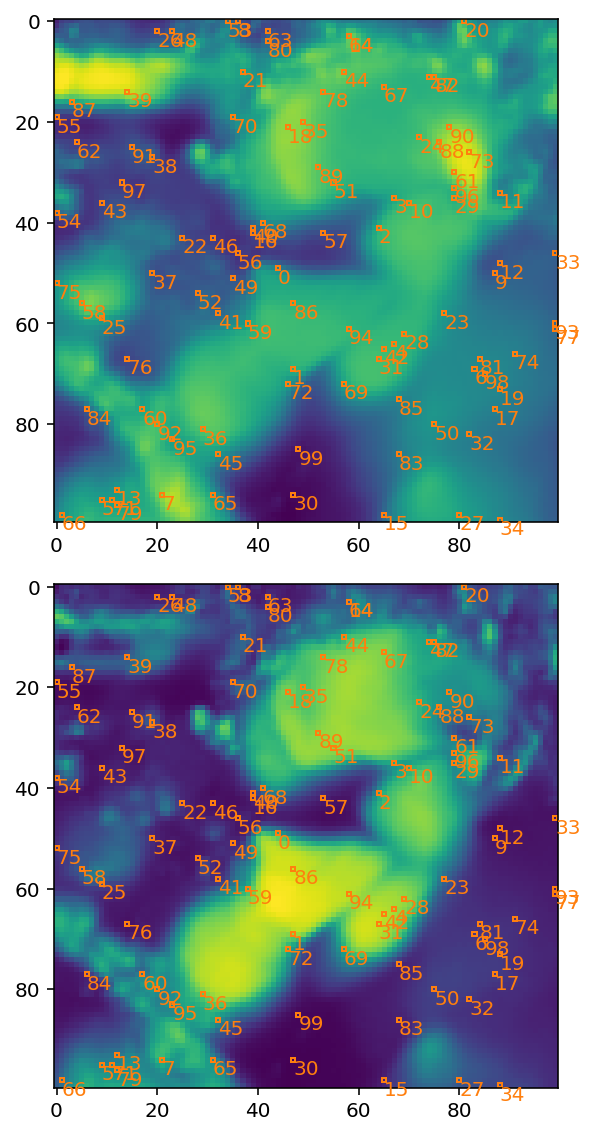

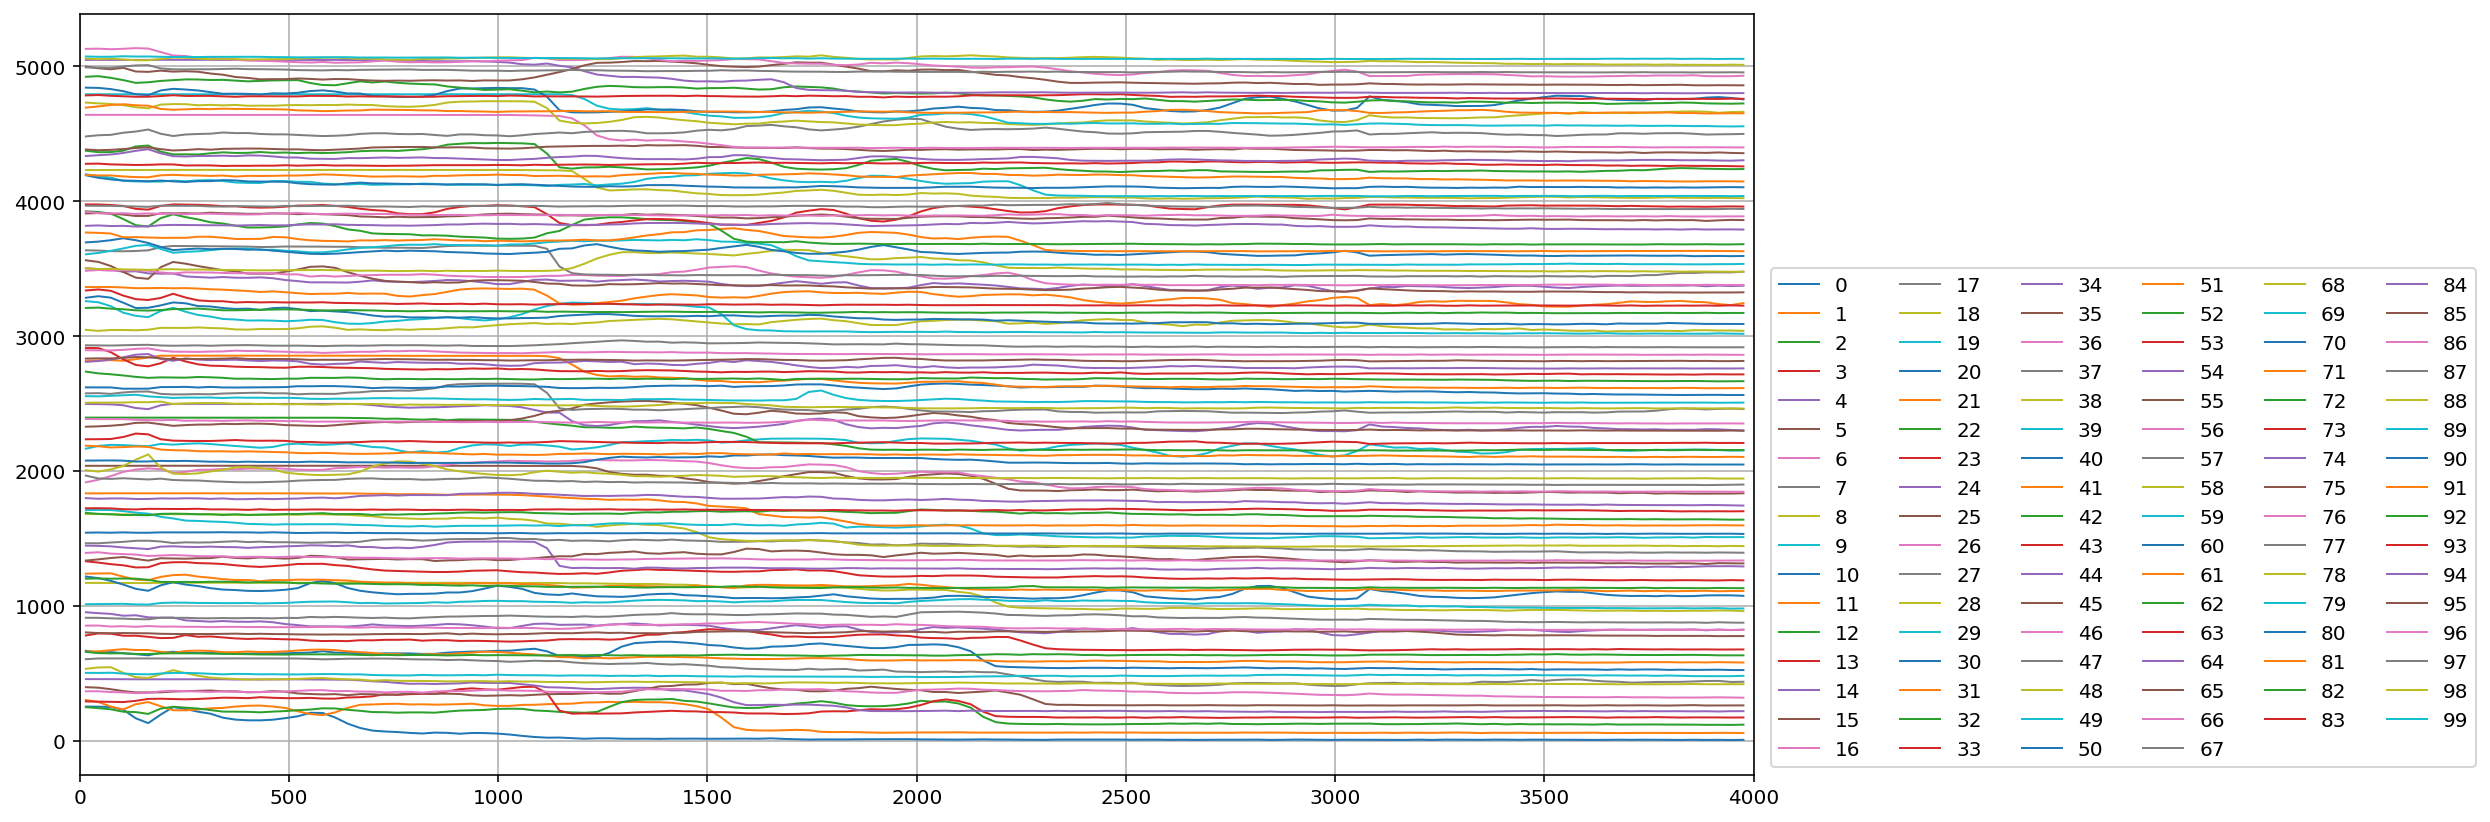

In [455]:
axs,rndProfiles = multiProfilePlotWithRoi(
    pxs,
    0,
    timeWindow=None,#(3000,time.max()),
    timeAverageWindow=tWin,
    times_=time,
    image_=subimage,
#     firstDeriv=True,
    stdDev=True,
    showRaw=False,
    imgHeight=4,
    onSame=True,
    outProfiles=True
)
# for ax in axs.flat:
#     ax.set_ylim(0,subimage.max())
# for ax in axs.flat:
#     ax.set_xticklabels([])

In [456]:
rndProfiles = np.array(rndProfiles)

In [457]:
smoothRndProfiles = rebin(rndProfiles,tWin,axis=1)
smoothTime = rebin(time,tWin)

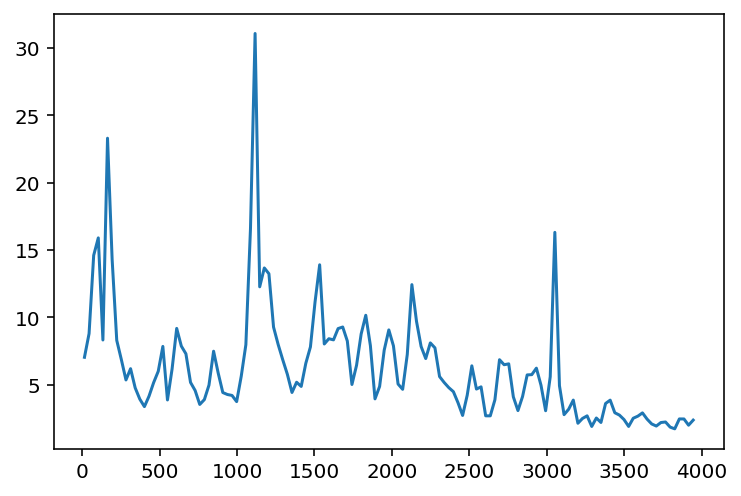

In [477]:
plt.plot(smoothTime[:-1],np.std(np.diff(smoothRndProfiles,axis=1),0))

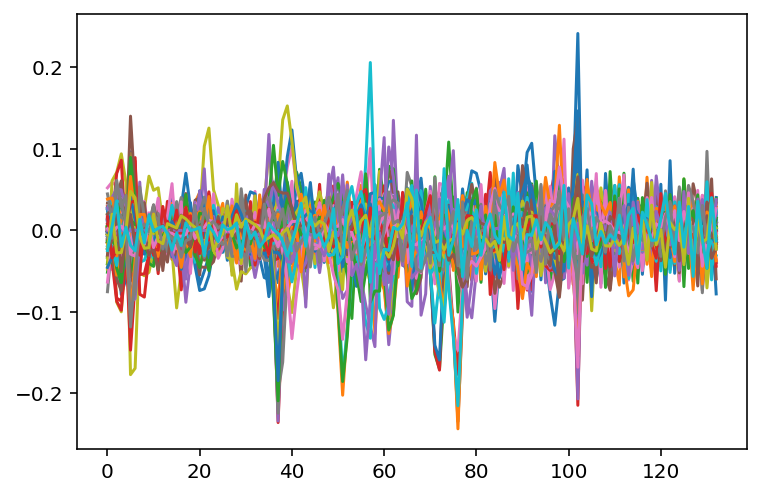

In [460]:
for p in smoothRndProfiles:
    plt.plot(np.diff(p)/(p[:-1]+p[1:]+1)/2)

In [470]:
%matplotlib inline

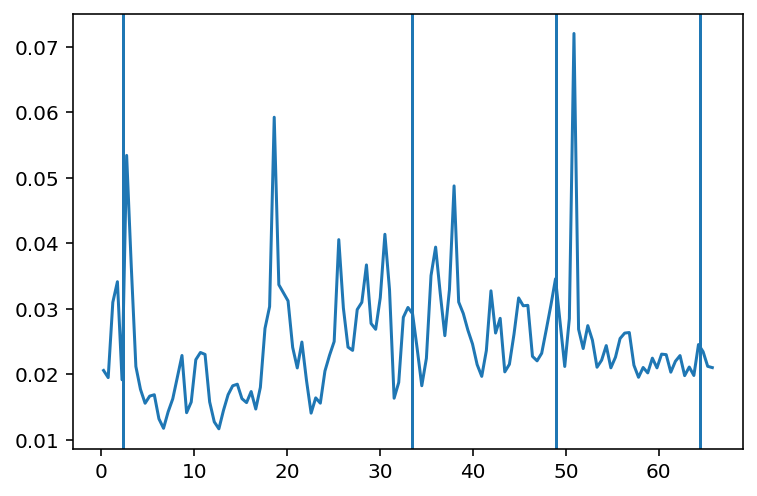

In [481]:
plt.plot(smoothTime[:-1]/60,np.std([np.diff(p)/(p[:-1]+p[1:]+1)/2 for p in smoothRndProfiles],0))
for t in np.array([35,3771,5630,7490])/2./60+2:
    plt.axvline(t)

array([  2.58333333,  64.31666667,  94.45      , 125.63333333])

In [ ]:
rndProfiles

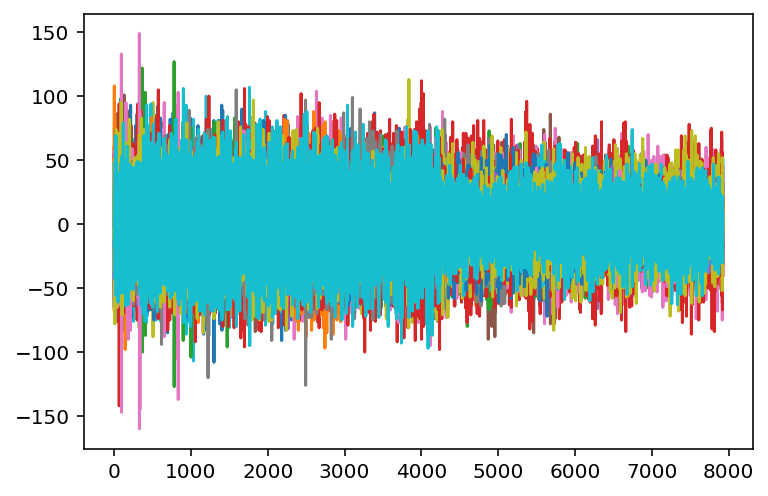

In [412]:
plt.plot(rndProfiles)

In [380]:
pxSize

0.5587442270058709

In [482]:
pxWin=2
pxShows = [(50+i*(2*pxWin+1),2*pxWin+j*(2*pxWin+1)) for i in range(8) for j in range(10)]

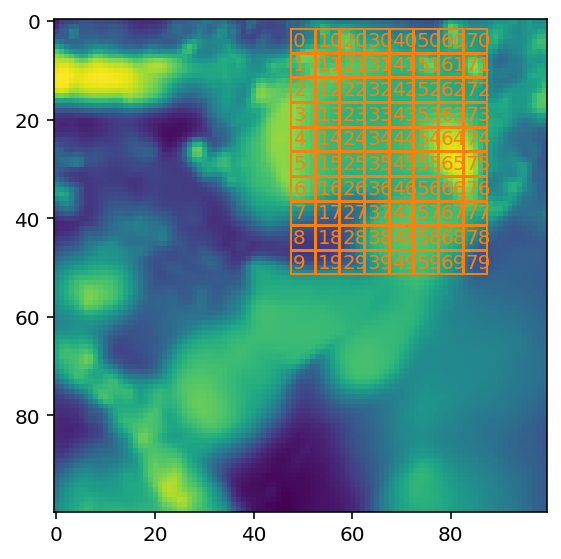

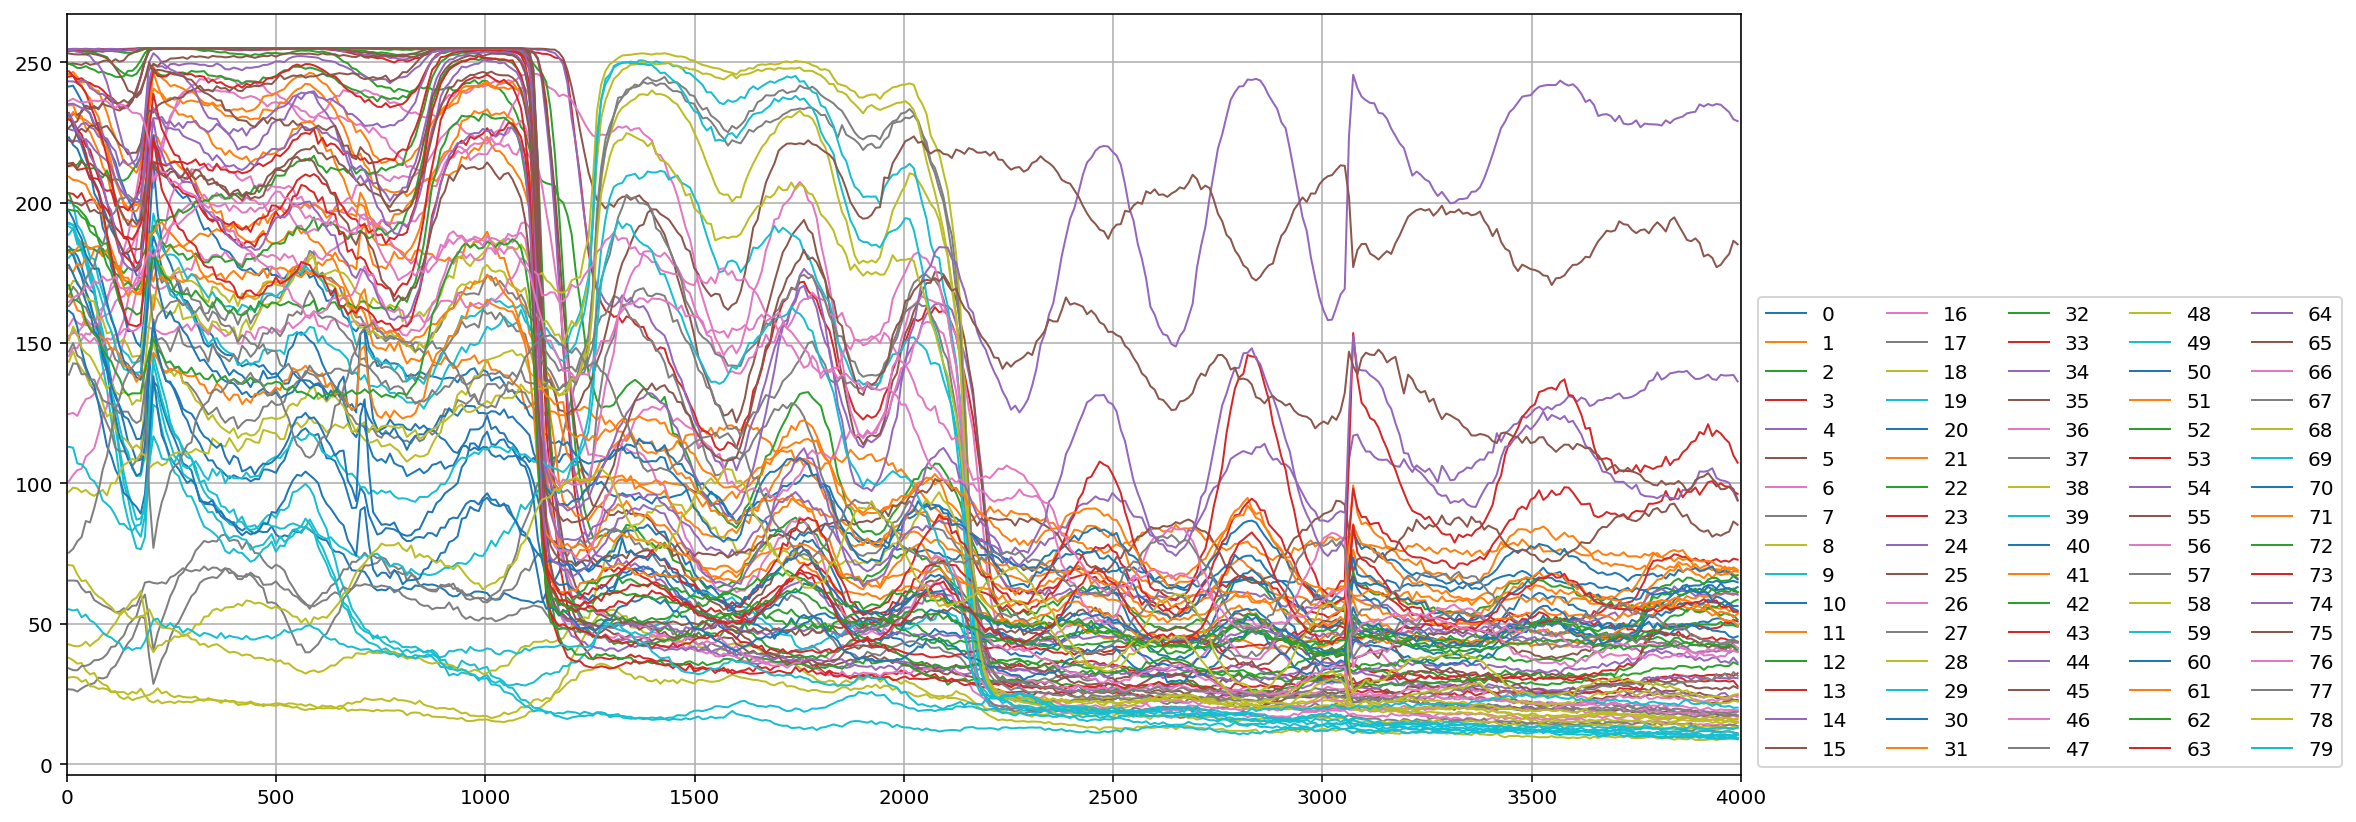

In [483]:
axs,roiProfiles = multiProfilePlotWithRoi(
    pxShows,
    pxWin,
    timeWindow=None,#(3000,time.max()),
    timeAverageWindow=20,
    times_=time,
    image_=subimage,
    firstDeriv=False,
    stdDev=False,
    showRaw=False,
    imgHeight=4,
    onSame=True,
    Offset_ = 0,
    outProfiles = True
)

In [484]:
roiProfiles = np.vstack(roiProfiles)

In [485]:
C = np.corrcoef(roiProfiles)

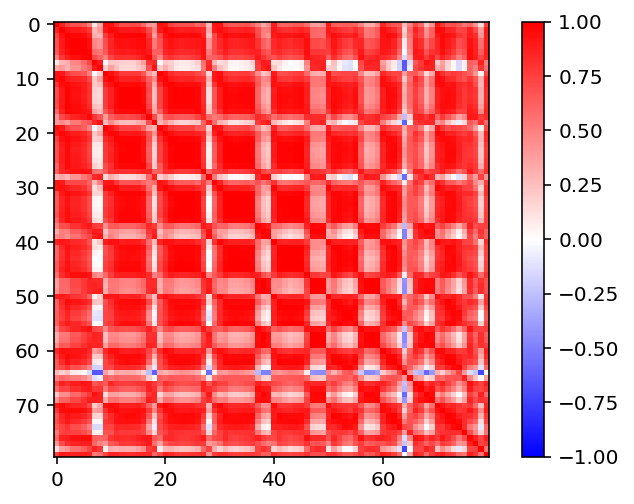

In [486]:
plt.imshow(C,vmin=-1,vmax=1,cmap="bwr")
plt.colorbar()

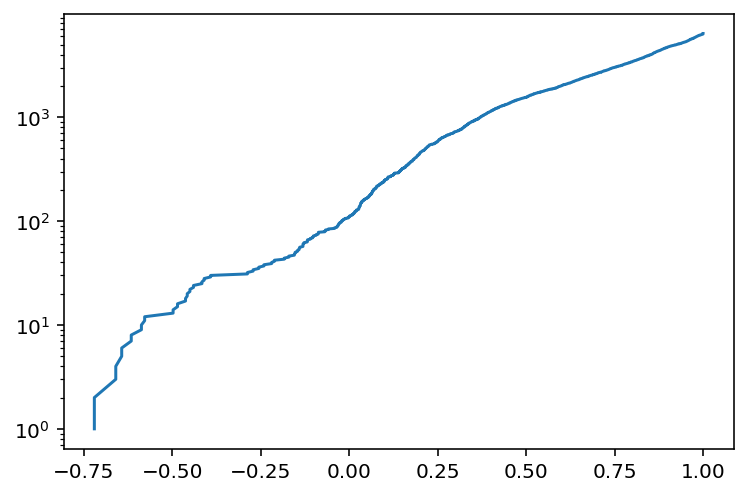

In [487]:
x = C.flatten()
plt.plot(sorted(x),np.arange(len(x))+1)
plt.yscale("log")

In [488]:
np.all([C<999,C>.95],axis=0)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

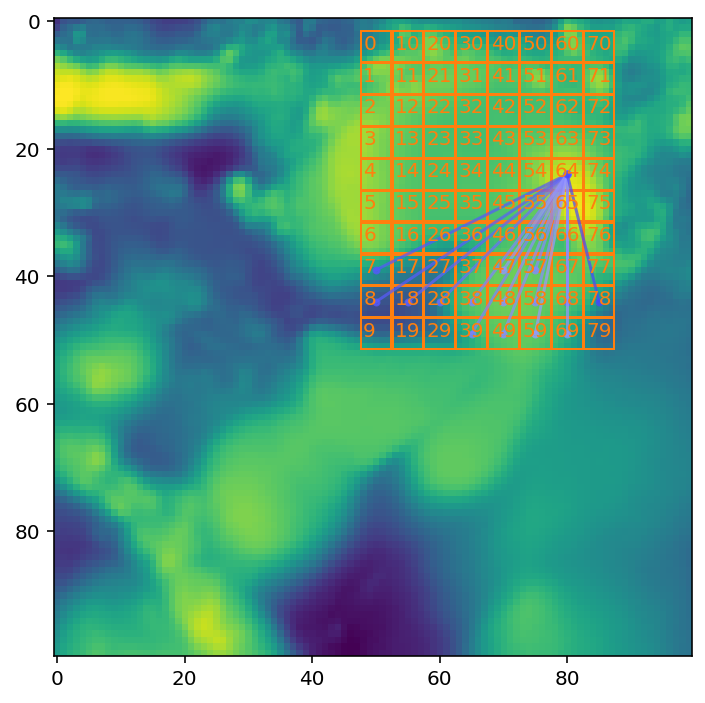

In [497]:
ax, = plotRoisOnImage(pxShows,pxWin,image_=subimage*100,imgHeight=5)
interestingPairs = []
for i,j in np.vstack([
    np.array(np.where(C<-.3)).T,
#     np.array(np.where(C> .997)).T
]):#zip(*np.where(C<-.4)):
    if j<=i: continue
    v = C[i,j]
    x,y = np.array(pxShows[i]),np.array(pxShows[j])
    if v>0 and np.linalg.norm(x-y)/(2*pxWin+1)<2: continue
    c = plt.cm.bwr((v+1)/2)
    plt.plot(*np.array([x,y]).T,marker=".",color=c,alpha = .7)
    interestingPairs += [(i,j)]

In [503]:
np.argsort(C[64])[::-1]

array([64, 63, 74, 54, 53, 73, 43, 44, 50, 55, 33, 52, 32, 42, 62, 34, 40,
       45, 23, 65, 24, 35, 30, 22, 75, 41, 25,  9, 31, 72, 36, 21, 19, 11,
       61, 13, 26, 14, 12, 70, 51, 20, 15,  0,  2, 10, 60, 16, 71,  1,  3,
        4, 46, 29, 79,  5, 27, 76,  6, 56, 77, 66, 17, 37, 67, 59, 69, 47,
       48, 49, 58, 57, 38, 39, 28, 68, 18,  8,  7, 78], dtype=int64)

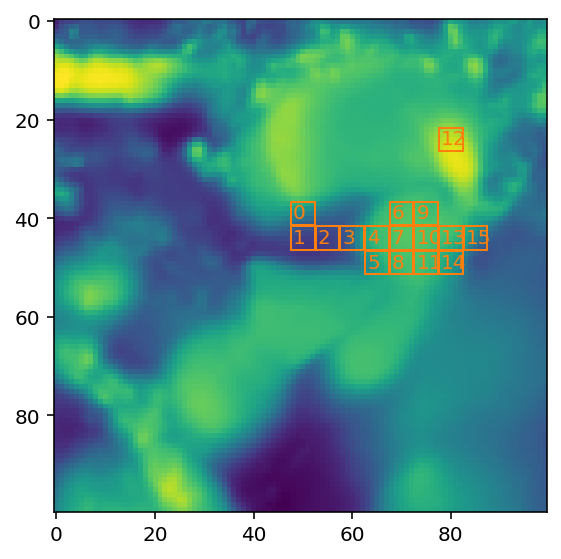

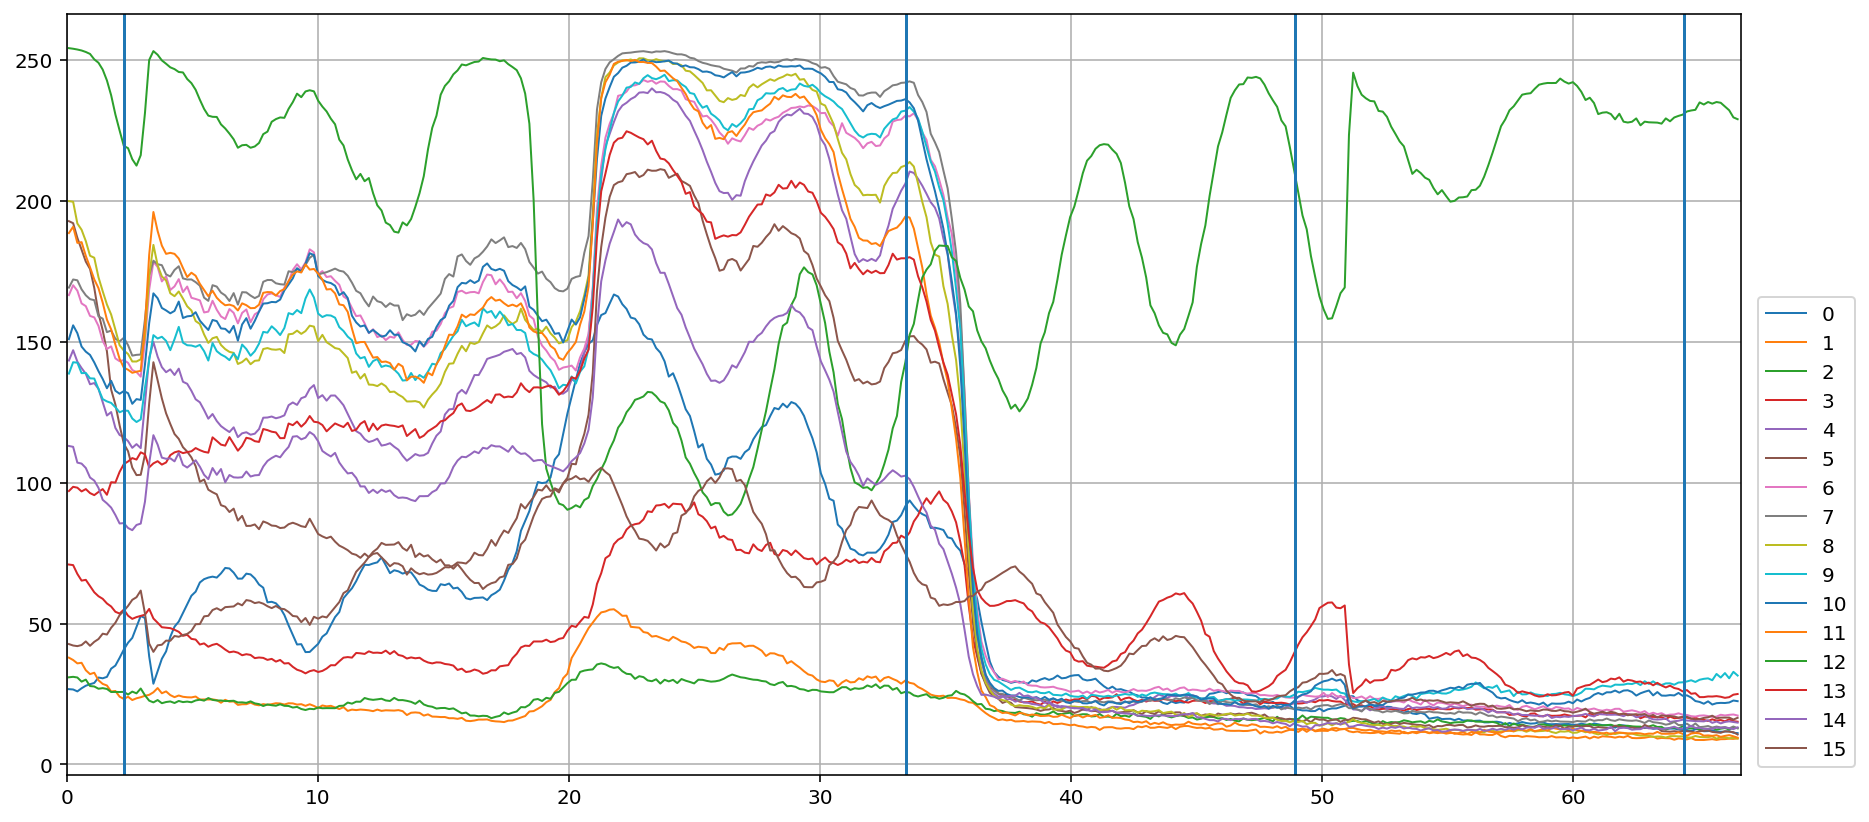

In [498]:
ax = multiProfilePlotWithRoi(
    [pxShows[j] for j in np.unique(interestingPairs)],
    pxWin,
    timeWindow=None,#(3000,time.max()),
    timeAverageWindow=20,
    times_=time/60,
    image_=subimage,
    firstDeriv=False,
    stdDev=False,
    showRaw=False,
    imgHeight=4,
    onSame=True,
    Offset_ = 0,
    outProfiles = False
)
for t in np.array([35,3771,5630,7490])/2./60+2:
    plt.axvline(t)

In [500]:
7500/subimage.shape[0]

0.9461334678945377

Our previous interpretation was wrong. We have no explanation for the sudden increase at t=20min.

In [504]:
import scipy.cluster.hierarchy as spc

In [514]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()

In [515]:
X = mm_scaler.fit_transform(roiProfiles[:])

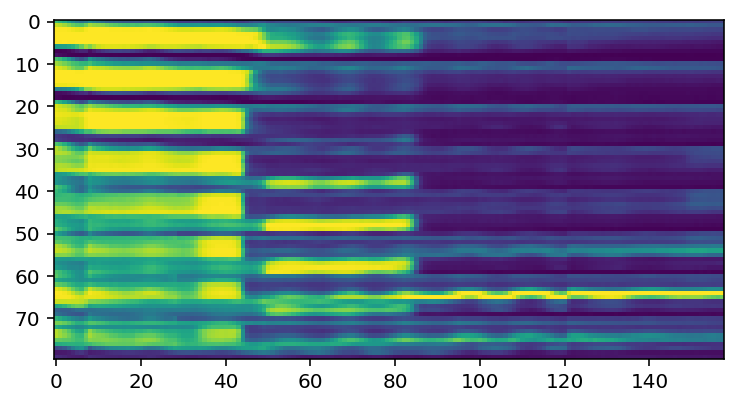

In [524]:
plt.imshow(rebin(X,50,1))

In [529]:
pdist = spc.distance.pdist(X,"correlation")
linkage = spc.linkage(pdist, method='complete',)

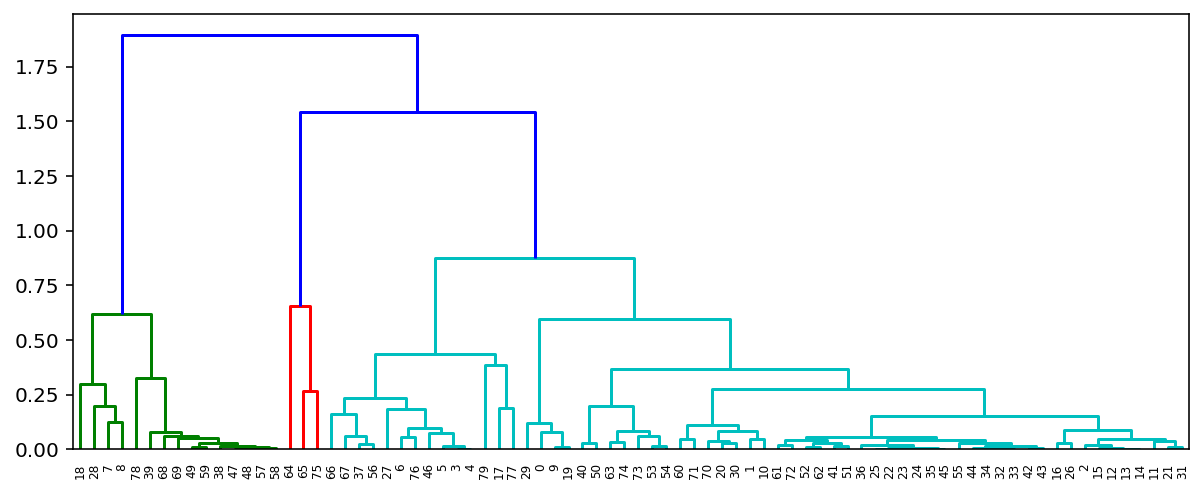

In [528]:
plt.figure(figsize=(10,4))
spc.dendrogram(linkage);

In [537]:
idx = spc.fcluster(linkage, .75, 'distance')

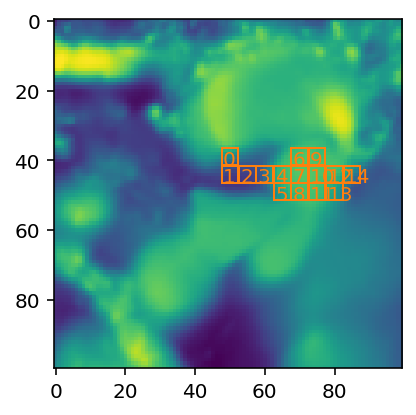

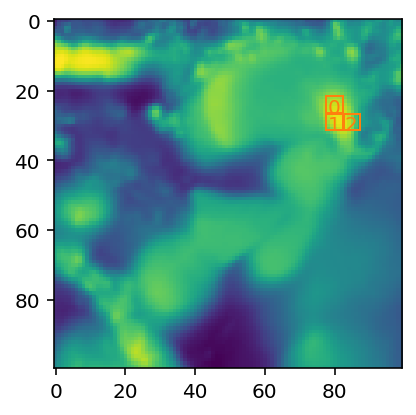

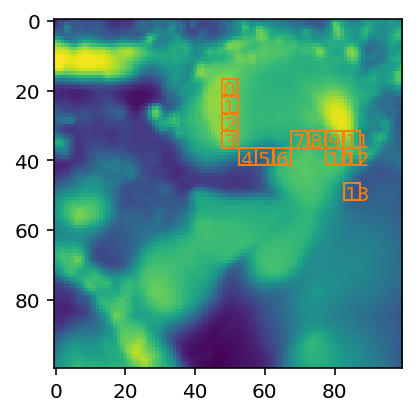

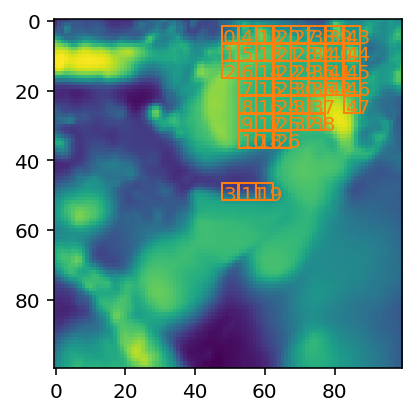

In [538]:
for i in np.unique(idx):
    plotRoisOnImage(np.array(pxShows)[idx==i],pxWin,image_=subimage,imgHeight=3)

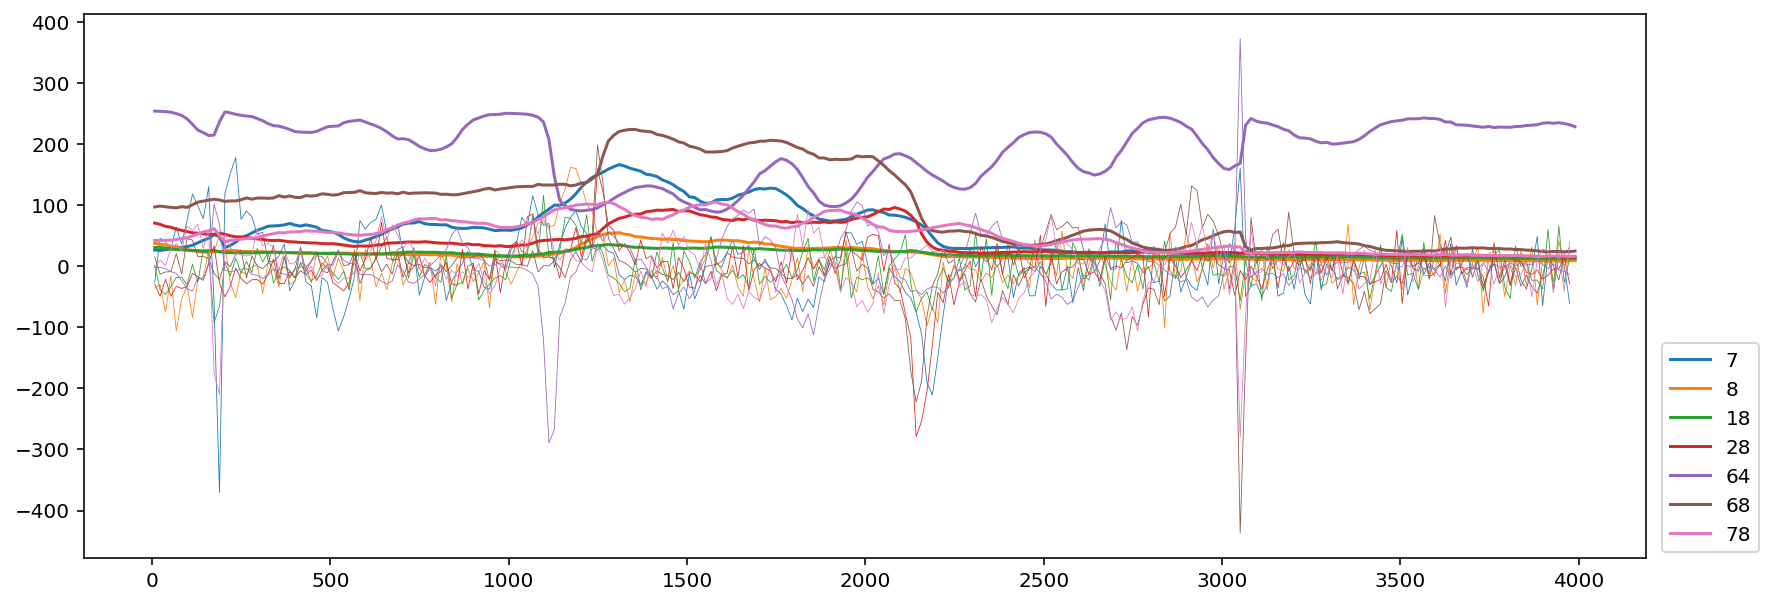

In [397]:
# %matplotlib notebook
# %matplotlib notebook

plt.figure(figsize=(14,5))
for j in np.unique(np.where(C<-.55)):
    tWin = 30
    t = rebin(time,tWin)
    x = rebin(roiProfiles[j],tWin)
    c = plt.plot(t,x,label=j)[0].get_color()
    plt.plot(t[:-1],np.diff(x)/x[:-1]*1000,c=c,lw=.4)
    
plt.legend(loc=(1.01,.01))

SyntaxError: invalid syntax (<ipython-input-373-937a9d8f3aee>, line 1)

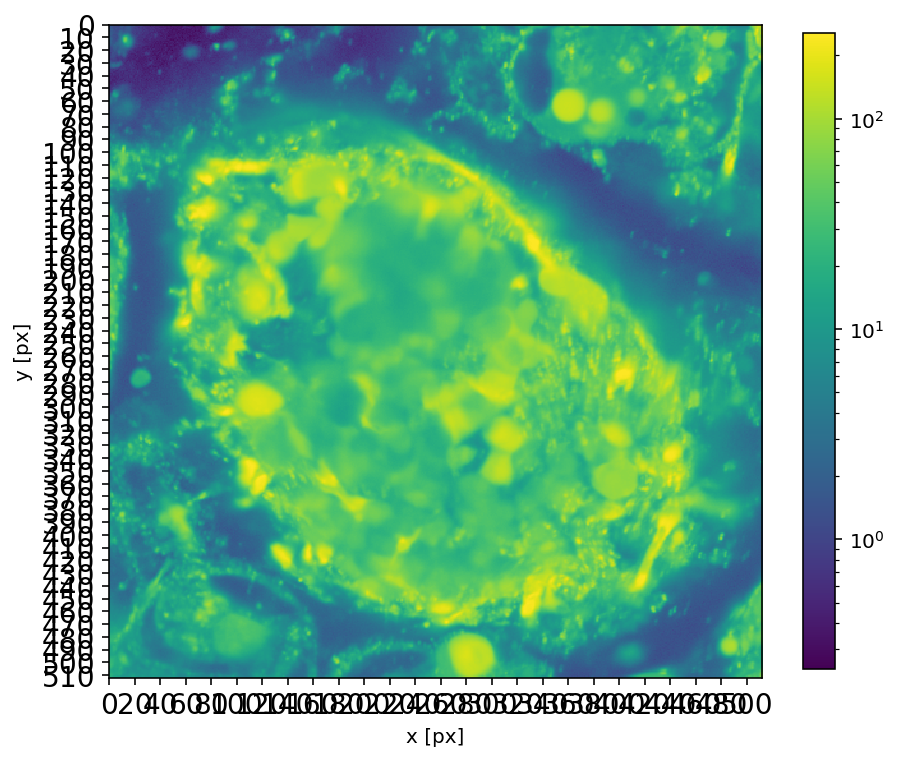

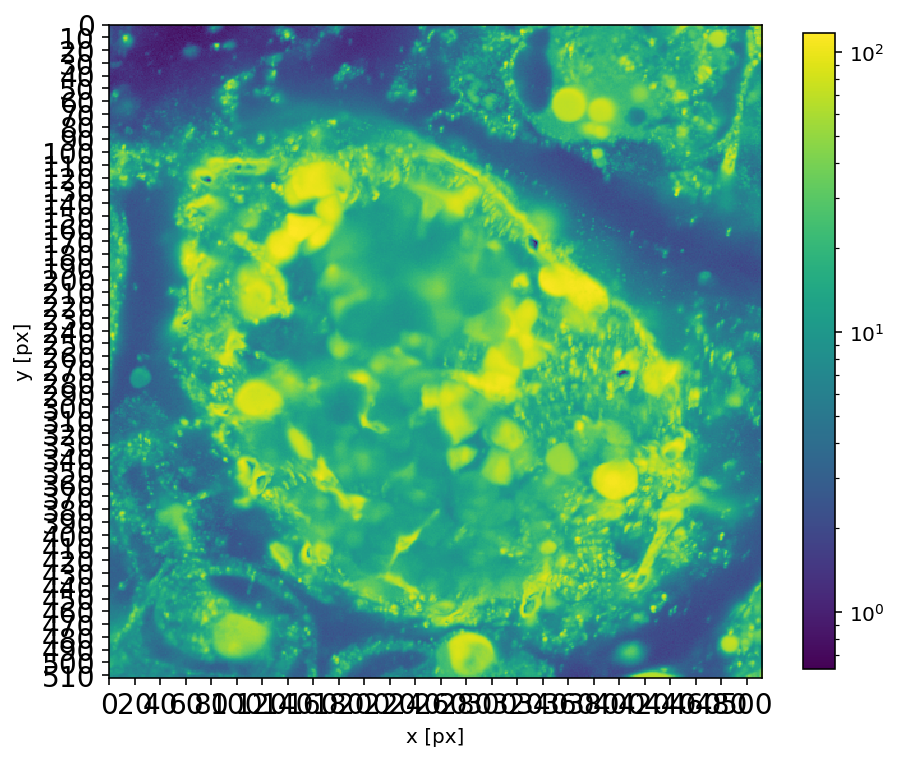

In [64]:
%matplotlib inline
plotImage(image[:].mean(axis=0).T,rescale=1/70,
          pxUnit="px",
#           pxSize=pxSize
         )
plotImage(image[:].std(axis=0).T,rescale=1/70,
          pxUnit="px",
#           pxSize=pxSize
         )

In [ ]:
p0 = 

In [ ]:
popt = curve_fit(decay,time,allProfile)[0]
plt.plot(x, decay(x,*popt))